### Merging ERA5 weather data with the penguin dataset

This notebook demonstrates how to merge the ERA5 weather data with the penguin dataset. For every penguin observation, the location and date of the observation are used to extract the weather data from the ERA5 dataset. The weather data is then merged with the penguin dataset by interpolating the weather data to the time of the observation using linear interpolation.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ERA5_FILES = '../data/era5_daily/*.nc'
PENGUIN_DATASET = '../data/penguin/penguins_final.csv'
MERGED_DATASET = '../data/penguin/penguins_final_with_era5.csv'

era5 = xr.open_mfdataset(ERA5_FILES, combine='by_coords')
penguin_df = pd.read_csv(PENGUIN_DATASET)

In [4]:
penguin_df['date_gmt'] = pd.to_datetime(penguin_df['date_gmt'])

'''
Create columns:
 - t2m: 2m temperature
 - tp: Total precipitation 
 - sst: Sea surface temperature
 - siconc: Sea ice concentration
 - sd: Snow depth
 - rsn: Snow density
 - avg_smr: Average snowfall 
'''
penguin_df['t2m'] = np.nan
penguin_df['tp'] = np.nan
penguin_df['sst'] = np.nan
penguin_df['siconc'] = np.nan
penguin_df['sd'] = np.nan
penguin_df['rsn'] = np.nan
penguin_df['avg_smr'] = np.nan


# Prepare target points for interpolation
target_lats = xr.DataArray(penguin_df['latitude_mean'].values, dims="points")
target_lons = xr.DataArray(penguin_df['longitude_mean'].values, dims="points")
target_times = xr.DataArray(penguin_df['date_gmt'].values, dims="points")

# Interpolate for all points at once
interpolated = era5.interp(latitude=target_lats, longitude=target_lons, valid_time=target_times)

'''
Assigning interpolated values to the penguin dataframe

Remark 1: Temperature is converted from Kelvin to Celsius (therefore -273)
Remark 2: Dataset contains means for 1 hour time intervals, therefore tp & avg_smr are multiplied by 24 to get daily values
'''
penguin_df['tp'] = interpolated['tp'].values * 24 
penguin_df['t2m'] = interpolated['t2m'].values - 273 
penguin_df['sst'] = interpolated['sst'].values - 273
penguin_df['siconc'] = interpolated['siconc'].values
penguin_df['sd'] = interpolated['sd'].values
penguin_df['rsn'] = interpolated['rsn'].values
penguin_df['avg_smr'] = interpolated['avg_smr'].values * 24


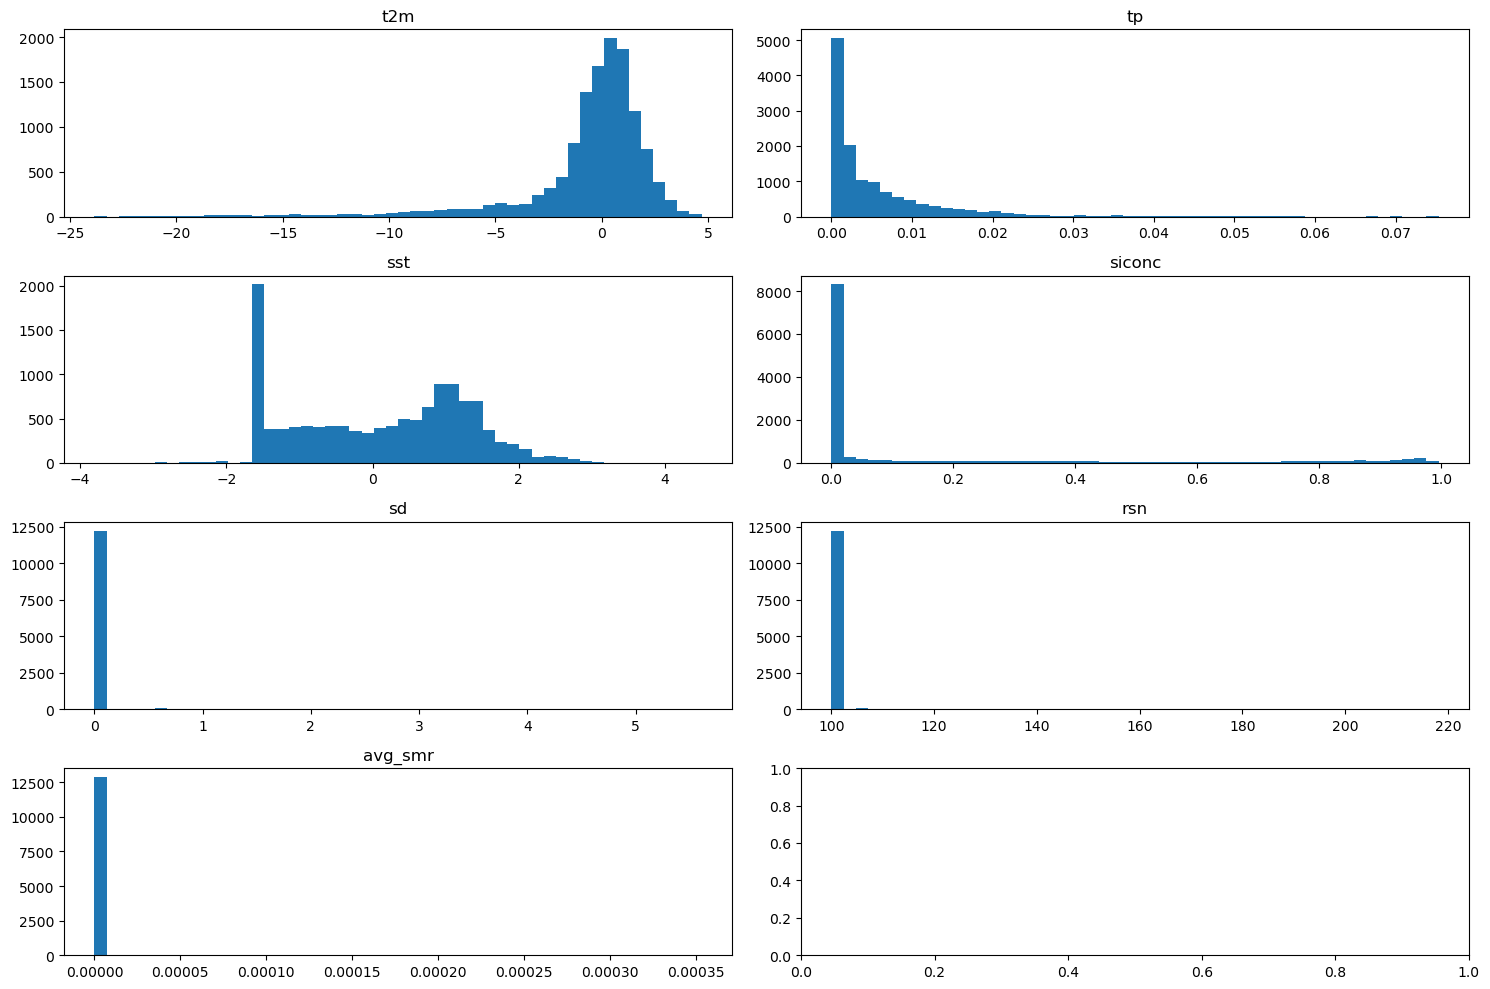

In [5]:
# plot histograms of distributions of the variables
fig, axs = plt.subplots(4, 2, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(['t2m', 'tp', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']):
    axs[i].hist(penguin_df[col], bins=50)
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()


In [6]:
# save the merged dataset
penguin_df.to_csv(MERGED_DATASET, index=False)